# Evaluate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

### 1. Reading the Dataset

In [2]:
df = pd.read_csv('../UPDATE-TSA-NOTEBOOKS/Data/Miles_Traveled.csv')
df.head()

DATE  TRFVOLUSM227NFWA
0  1970-01-01           80173.0
1  1970-02-01           77442.0
2  1970-03-01           90223.0
3  1970-04-01           89956.0
4  1970-05-01           97972.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
DATE                588 non-null object
TRFVOLUSM227NFWA    588 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [5]:
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
df.head()

ds        y
0 1970-01-01  80173.0
1 1970-02-01  77442.0
2 1970-03-01  90223.0
3 1970-04-01  89956.0
4 1970-05-01  97972.0

In [7]:
df.plot(x='ds',y='y');

### 3. Train Test Split

In [8]:
len(df)

588

In [10]:
# One year for Testing Dataset
train = df.iloc[:576]
test = df.iloc[576:]

### 4. Model

In [11]:
from fbprophet import Prophet
m = Prophet()
m.fit(train)

/home/eduardo/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# In Stead of doing df.index.freq = 'MS' as we do in Statsmodel
future = m.make_future_dataframe(periods=12,freq='MS')
preds = m.predict(future)
preds.head() # to find out more about the output

ds         trend  ...  multiplicative_terms_upper           yhat
0 1970-01-01  94162.298231  ...                         0.0   75573.837088
1 1970-02-01  94474.349513  ...                         0.0   67373.907890
2 1970-03-01  94756.202283  ...                         0.0   94730.084020
3 1970-04-01  95068.253565  ...                         0.0   95102.981973
4 1970-05-01  95370.238676  ...                         0.0  104990.722316

[5 rows x 16 columns]

In [14]:
# yhat, yhat_lower and yhat_upper are probably the most important terms of this DF
preds[['ds','yhat_lower','yhat_upper','yhat']].tail(12)

ds     yhat_lower     yhat_upper           yhat
576 2018-01-01  238136.904728  249563.369223  243850.453937
577 2018-02-01  229728.450625  241144.627908  235480.588794
578 2018-03-01  257069.778654  268394.077224  262683.274392
579 2018-04-01  257046.668221  268773.722917  262886.236399
580 2018-05-01  266922.844606  278768.511903  272609.522601
581 2018-06-01  267353.232961  278588.125055  272862.615300
582 2018-07-01  273560.983037  284440.381708  279321.841101
583 2018-08-01  273906.706498  285717.693334  279858.813654
584 2018-09-01  256071.256701  267694.724551  261882.497404
585 2018-10-01  263577.191001  274829.651134  268995.952784
586 2018-11-01  250028.297369  261661.335175  255623.575305
587 2018-12-01  251209.242150  262635.710226  257047.376280

### 5. Plotting the Results

In [19]:
ax = preds.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,6))
test.plot(x='ds',y='y',label='Test Data',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'));

### 6. Evaluate the Model

In [26]:
from statsmodels.tools.eval_measures import rmse
# Alternative:
# from sklearn.metrics import mean_squared_error
RMSE = rmse(test['y'],preds['yhat'][-12:])
RMSE

8618.783155559411

In [27]:
test['y'].mean()

268739.6666666667

In [28]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [31]:
# The initial period should be long enough to capture all of the components of the model, 
# in particular seasonalities and extra regressors: at least a year for yearly seasonality,
# at least a week for weekly seasonality, etc.

# Initial training period
initial = 5 * 365
initial = str(initial) + ' days'
# Period lenght that we are going to perform the cross validation. How many times to fold?
period = 5 * 365
period = str(period) + ' days'
# Horizon of prediction for essentially each fold
horizon = 365
horizon = str(horizon) + ' days'

In [32]:
df_cv = cross_validation(m,initial=initial,period=period,horizon=horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00
/home/eduardo/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/eduardo/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/eduardo/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/home/eduardo/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version

In [33]:
df_cv.head()

ds           yhat     yhat_lower     yhat_upper         y     cutoff
0 1977-01-01  108470.618904  106949.688414  109913.369027  102445.0 1976-12-11
1 1977-02-01  102999.275720  101645.580618  104340.937308  102416.0 1976-12-11
2 1977-03-01  118894.097843  117533.778843  120451.028996  119960.0 1976-12-11
3 1977-04-01  120535.080258  119095.122667  122159.032514  121513.0 1976-12-11
4 1977-05-01  127801.862911  126348.947975  129319.586367  128884.0 1976-12-11

In [34]:
len(df_cv)

108

In [35]:
performance_metrics(df_cv)

horizon           mse         rmse          mae      mape  coverage
1    52 days  2.401243e+07  4900.247503  4505.853953  0.027625       0.3
13   53 days  2.150848e+07  4637.723095  4238.979154  0.024866       0.3
25   54 days  1.807726e+07  4251.735826  3709.259697  0.019936       0.4
37   55 days  2.298242e+07  4793.998548  4236.591665  0.023045       0.3
49   57 days  2.078973e+07  4559.576152  3972.403692  0.021320       0.4
61   58 days  2.306581e+07  4802.688294  4249.232759  0.022525       0.3
73   59 days  3.794283e+07  6159.775245  5069.548970  0.026224       0.3
85   60 days  3.875144e+07  6225.065817  5137.257092  0.026705       0.3
97   62 days  3.722173e+07  6100.960990  4941.594534  0.025848       0.4
2    80 days  3.262391e+07  5711.734069  4361.785910  0.023930       0.5
14   81 days  3.286849e+07  5733.104654  4470.372677  0.024663       0.5
26   82 days  3.283390e+07  5730.087552  4465.181064  0.023638       0.5
38   84 days  3.392440e+07  5824.465213  4741.626737  0.025029       0.5
50   85 days  3.000005e+07  5477.230279  4385.231909  0.022237       0.6
62   86 days  2.920570e+07  5404.230274  4126.698459  0.020803       0.6
74   87 days  2.790509e+07  5282.526908  3991.797456  0.019761       0.7
86   89 days  1.455510e+07  3815.114181  3306.788159  0.016220       0.7
98   90 days  2.085718e+07  4566.966458  3689.879146  0.017122       0.7
3   111 days  2.009388e+07  4482.619582  3494.594847  0.016635       0.7
15  112 days  2.062248e+07  4541.198054  3641.424480  0.017698       0.7
27  113 days  2.239112e+07  4731.925605  3926.974960  0.019227       0.6
39  115 days  2.182344e+07  4671.556790  3825.519987  0.018361       0.7
51  116 days  2.114341e+07  4598.196257  3701.079674  0.017534       0.7
63  117 days  1.975949e+07  4445.165272  3344.944180  0.015846       0.7
75  118 days  2.099761e+07  4582.314378  3673.295511  0.017139       0.7
87  120 days  1.931193e+07  4394.534606  3316.442069  0.015774       0.7
99  121 days  4.006536e+07  6329.720141  4257.620380  0.019071       0.7
4   141 days  2.989894e+07  5467.992505  3351.757312  0.016118       0.8
16  142 days  3.349749e+07  5787.701543  3861.762986  0.019646       0.7
28  143 days  3.438552e+07  5863.916479  3999.526410  0.020026       0.6
..       ...           ...          ...          ...       ...       ...
80  271 days  3.937608e+07  6275.036329  4939.559952  0.023139       0.4
92  273 days  4.760122e+07  6899.363639  5497.536396  0.025703       0.4
104 274 days  5.213059e+07  7220.151507  6023.433967  0.027710       0.3
9   294 days  4.297291e+07  6555.372283  5072.509344  0.024378       0.4
21  295 days  4.779577e+07  6913.448718  5675.256778  0.028637       0.3
33  296 days  4.445201e+07  6667.233800  5357.673214  0.025814       0.3
45  298 days  4.284120e+07  6545.319089  4994.574733  0.023564       0.4
57  299 days  4.492110e+07  6702.320176  5341.726110  0.025043       0.3
69  300 days  4.491227e+07  6701.661616  5332.975023  0.024974       0.3
81  301 days  4.029252e+07  6347.638998  4859.685660  0.022833       0.4
93  303 days  2.450696e+07  4950.450007  3734.443415  0.018242       0.5
105 304 days  4.007687e+07  6330.629461  4327.542957  0.019757       0.5
10  325 days  3.539323e+07  5949.220739  3746.613886  0.018067       0.6
22  326 days  3.671951e+07  6059.662123  4104.792823  0.020886       0.5
34  327 days  3.203095e+07  5659.589236  3555.572080  0.016810       0.6
46  329 days  3.763351e+07  6134.615471  4021.843482  0.019307       0.6
58  330 days  3.850664e+07  6205.372268  4279.798761  0.020574       0.6
70  331 days  3.723985e+07  6102.446254  4118.399804  0.019787       0.7
82  332 days  4.112002e+07  6412.489620  4696.950659  0.022141       0.6
94  334 days  4.083617e+07  6390.318482  4632.143684  0.021955       0.6
106 335 days  4.738572e+07  6883.728394  5314.445644  0.024594       0.5
11  355 days  2.221554e+07  4713.336504  3974.210177  0.021138       0.5
23  356 days  2.390561e+07  4889.336507  4287.818119  0.023540 

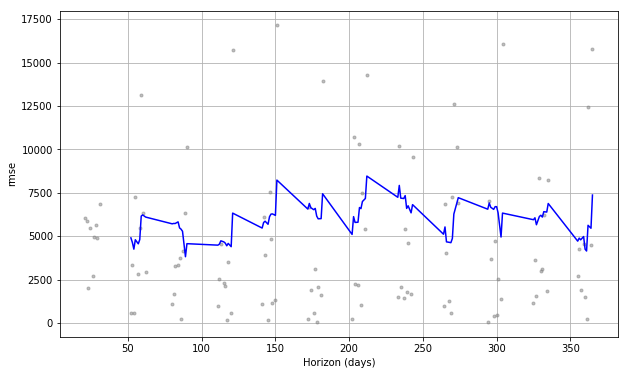

In [38]:
plot_cross_validation_metric(df_cv,metric='rmse');